In [1]:
import cmsisdsp as dsp
import numpy as np
from scipy import signal
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import pandas as pd

from filt_plot_funcs import *

fs = 200


In [2]:
def printBiquadInArmFormat(sos):
    # Remove `a0` coefficients and flip sign of `a1` and `a2`
    sos = np.float32(sos)
    sos = np.delete(sos, 3, 1)
    sos[:, 3:] *= -1
    
    # Print sections
    print("{", end='\n')
    for section_num, section in enumerate(sos):
        print((" " * 4) + f"// Section {section_num+1}\n", end='')
        for idx, val in enumerate(section):
            if idx == 0 or idx == 3: print(" " * 4, end='')
            print(f"{val}f, ", end='')
            if idx == 2: print("\n", end='')
            
        print("\n", end='')
    
    print("};", end='')
    
    return


## DAQ

### High Pass Filter

In [3]:
sos_high = signal.iirfilter(N=4, Wn=0.5, btype="highpass", rs=10, ftype='cheby2', fs=fs, output='sos')
printBiquadInArmFormat(sos_high)


{
    // Section 1
    0.9903915524482727f, -1.9807473421096802f, 0.9903915524482727f, 
    1.9863483905792236f, -0.986438512802124f, 
    // Section 2
    1.0f, -1.9997893571853638f, 1.0f, 
    1.994096040725708f, -0.9943605065345764f, 
};

In [4]:
z_high, p_high, k_high = signal.sos2zpk(sos_high)
print(f"abs(p) = {np.abs(p_high)}")


abs(p) = [0.99319611 0.99319611 0.99717626 0.99717626]


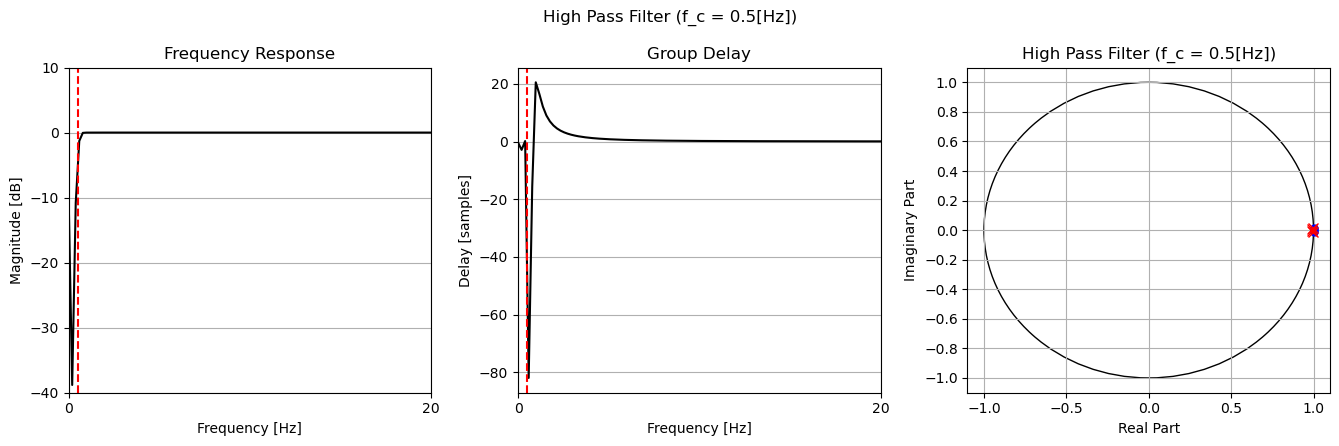

In [5]:
fig_high, axs_high = plt.subplots(1, 3, tight_layout=True, figsize=[13.5, 4.5])

b_high, a_high = signal.sos2tf(sos_high)
plot_freq_domain(b_high, a_high, fs=fs, in_dB=True, ax1=axs_high[0], ax2=axs_high[1], filt_name="High Pass Filter (f_c = 0.5[Hz])")
plot_pole_zero(b_high, a_high, ax=axs_high[2], filt_name="High Pass Filter (f_c = 0.5[Hz])")

for i in range(2):
    plt.sca(axs_high[i])
    plt.xlim([0, 20])
    plt.axvline(0.5, linestyle='dashed', color='r')
    if i == 0: plt.ylim([-40, 10])


### Low Pass Filter

In [6]:
sos1 = signal.iirfilter(N=4, Wn=40, btype="lowpass", rs=10, ftype='cheby2', fs=fs, output='sos')
printBiquadInArmFormat(sos1)


{
    // Section 1
    0.3271741271018982f, 0.3701258897781372f, 0.3271741271018982f, 
    -0.20968256890773773f, -0.1729172021150589f, 
    // Section 2
    1.0f, -0.4715292155742645f, 1.0f, 
    0.5868059992790222f, -0.7193671464920044f, 
};

abs(p) = [0.41583315 0.41583315 0.84815515 0.84815515]


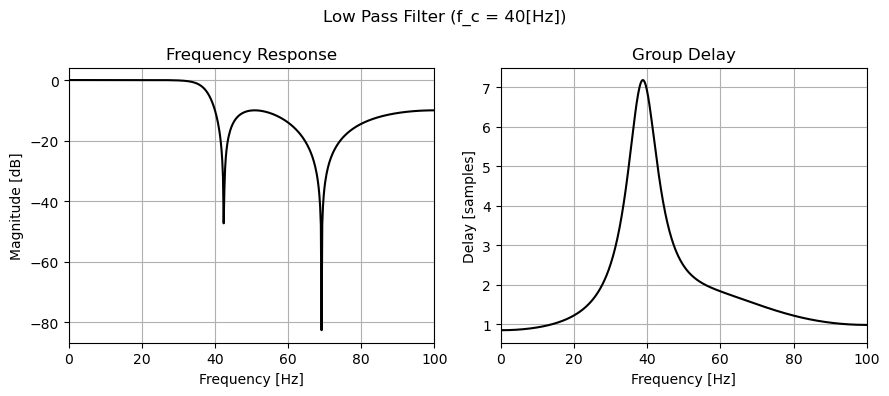

<Figure size 640x480 with 0 Axes>

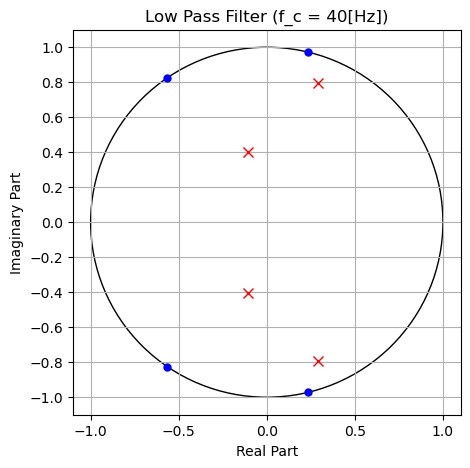

In [7]:
z_low, p_low, k_low = signal.sos2zpk(sos1)
print(f"abs(p) = {np.abs(p_low)}")

b1, a1 = signal.sos2tf(sos1)

plot_freq_domain(b1, a1, fs=fs, in_dB=True, filt_name="Low Pass Filter (f_c = 40[Hz])")
plot_pole_zero(b1, a1, filt_name="Low Pass Filter (f_c = 40[Hz])")

### IIR Notch Filter

In [8]:
sos2 = signal.iirfilter(N=6, Wn=[59, 61], btype='bandstop', output='sos', fs=fs)
printBiquadInArmFormat(sos2)


{
    // Section 1
    0.8856732845306396f, 0.5476464033126831f, 0.8856732845306396f, 
    -0.5850160717964172f, -0.9409302473068237f, 
    // Section 2
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.615153431892395f, -0.9412328004837036f, 
    // Section 3
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.5631667971611023f, -0.9562366008758545f, 
    // Section 4
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.6460562348365784f, -0.9568508863449097f, 
    // Section 5
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.5554963946342468f, -0.9837208390235901f, 
    // Section 6
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.6700929999351501f, -0.9840363264083862f, 
};

In [9]:
z_notch, p_notch, k_notch = signal.sos2zpk(sos2)
print(f"abs(p) = {np.abs(p_notch)}")


abs(p) = [0.97001559 0.97001559 0.97017153 0.97017153 0.97787352 0.97787352
 0.97818754 0.97818754 0.99182701 0.99182701 0.99198604 0.99198604]


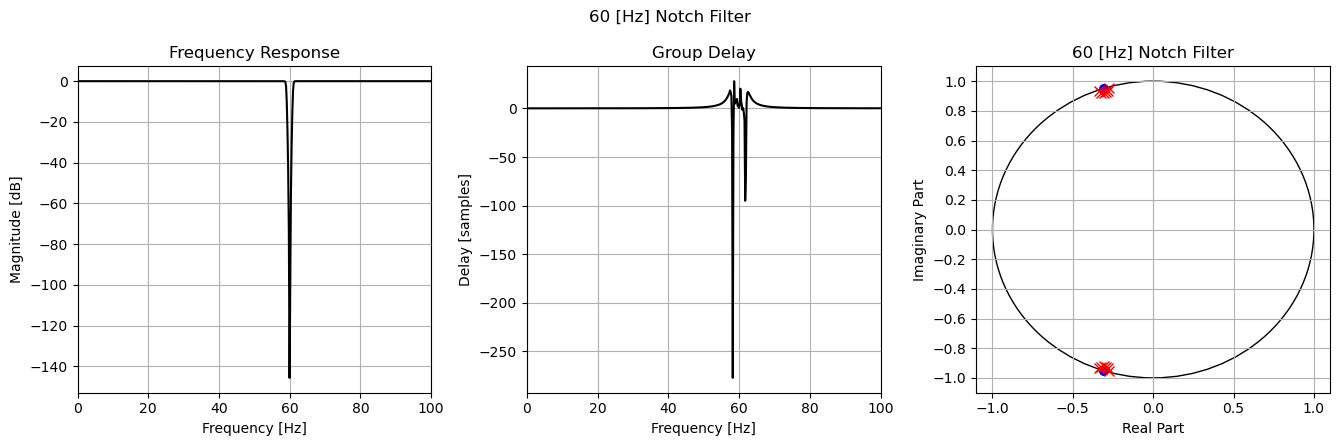

In [10]:
fig_notch, axs_notch = plt.subplots(1, 3, tight_layout=True, figsize=[13.5, 4.5])

b2, a2 = signal.sos2tf(sos2)
plot_freq_domain(b2, a2, fs=fs, in_dB=True, ax1=axs_notch[0], ax2=axs_notch[1], filt_name="60 [Hz] Notch Filter")
plot_pole_zero(b2, a2, ax=axs_notch[2], filt_name="60 [Hz] Notch Filter")


### Overall Filter

In [11]:
z_overall = np.concatenate([z_high, z_low, z_notch])
p_overall = np.concatenate([p_high, p_low, p_notch])
k_overall = k_high * k_low * k_notch

print(np.sort(np.abs(p_overall)))

[0.41583315 0.41583315 0.84815515 0.84815515 0.97001559 0.97001559
 0.97017153 0.97017153 0.97787352 0.97787352 0.97818754 0.97818754
 0.99182701 0.99182701 0.99198604 0.99198604 0.99319611 0.99319611
 0.99717626 0.99717626]


In [12]:
sos_overall = signal.zpk2sos(z_overall, p_overall, k_overall)
printBiquadInArmFormat(sos_overall)

{
    // Section 1
    0.2869851589202881f, 0.32466086745262146f, 0.2869851589202881f, 
    -0.20968256890773773f, -0.1729172021150589f, 
    // Section 2
    1.0f, -0.4715292155742645f, 1.0f, 
    0.5868059992790222f, -0.7193671464920044f, 
    // Section 3
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.5850160717964172f, -0.9409302473068237f, 
    // Section 4
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.615153431892395f, -0.9412328004837036f, 
    // Section 5
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.5631667971611023f, -0.9562366008758545f, 
    // Section 6
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.6460562348365784f, -0.9568508863449097f, 
    // Section 7
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.5554963946342468f, -0.9837208390235901f, 
    // Section 8
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.6700929999351501f, -0.9840363264083862f, 
    // Section 9
    1.0f, -1.9999638795852661f, 1.0f, 
    1.9863483905792236f, -0.986438512802124f, 
    // Section 10
    1.0f, -1.9

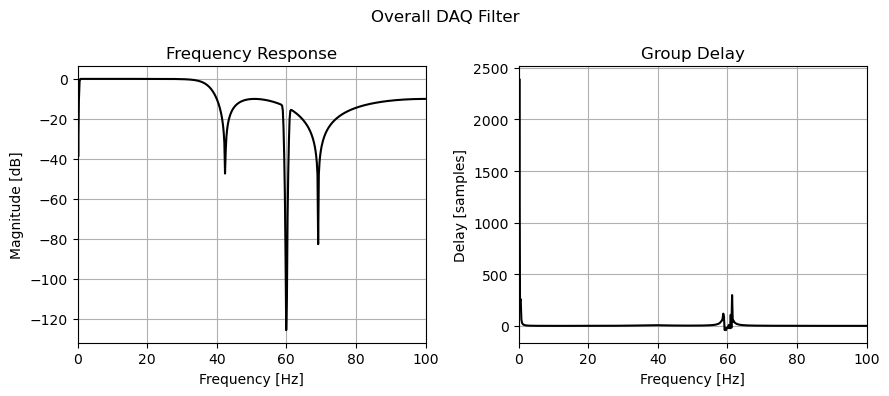

<Figure size 640x480 with 0 Axes>

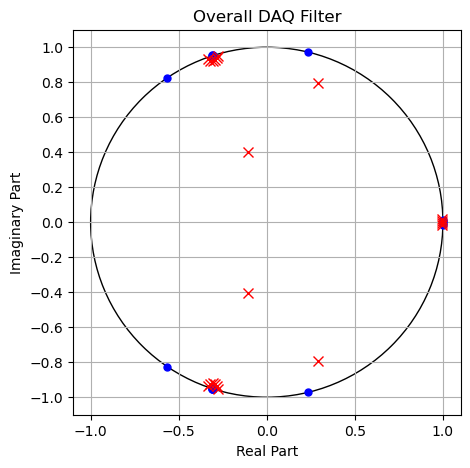

In [13]:
b_overall, a_overall = signal.sos2tf(sos_overall)

plot_freq_domain(b_overall, a_overall, fs=fs, in_dB=True, filt_name="Overall DAQ Filter")
plot_pole_zero(b_overall, a_overall, filt_name="Overall DAQ Filter")

### DAQ Filter Test

In [14]:
data = pd.read_csv("../../data/101.csv")
data.describe()

,Unnamed: 0,0
count,361111.000000,361111.000000
mean,180555.000000,-0.284222
std,104243.910866,0.261132
min,0.000000,-3.165415
25%,90277.500000,-0.401950
50%,180555.000000,-0.329274
75%,270832.500000,-0.235140
max,361110.000000,2.418641


In [15]:
xn = np.array(data.iloc[:,1])

N = len(xn)
n = np.linspace(0, N, N)
t = n / fs

# Generate 60 [Hz] noise
noise = np.sin(2 * np.pi * 60 * t) * (1.1 * xn)
x1n = xn + noise

# Filter
yn = signal.lfilter(b_overall, a_overall, x1n)


In [16]:
Xf = rfft(xn, N)
X1f = rfft(x1n, N)
Yf = rfft(yn, N)

f = rfftfreq(N, 1/fs)

In [17]:
pd.DataFrame(np.real(X1f)).describe()

,0
count,180556.000000
mean,-0.526070
std,306.019514
min,-102449.802940
25%,-57.062619
50%,0.098776
75%,57.477620
max,40277.570802


/Users/bryanmcelvy/opt/anaconda3/envs/ecg_hrm_py/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/bryanmcelvy/opt/anaconda3/envs/ecg_hrm_py/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


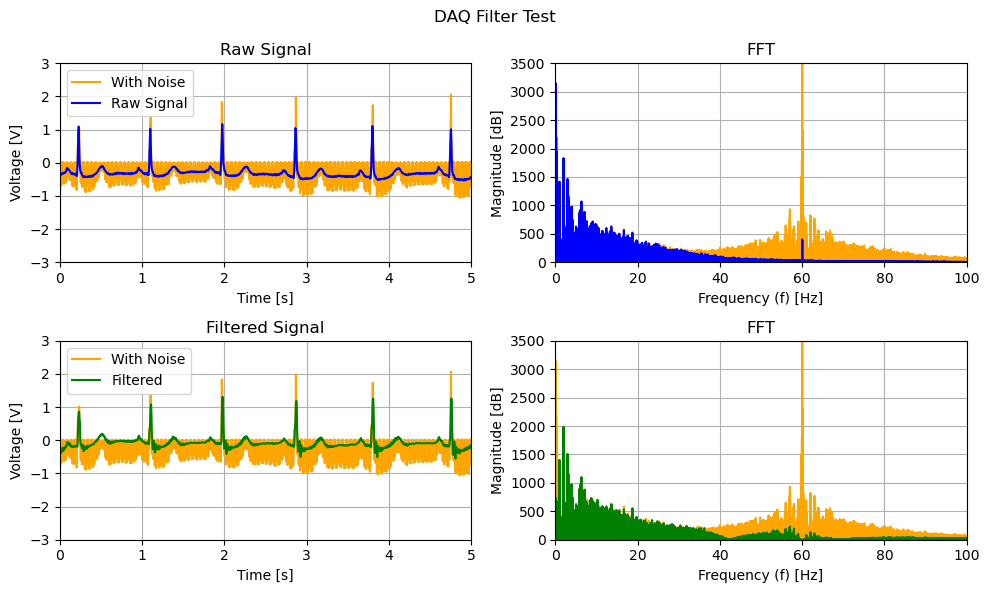

In [21]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=[10, 6])
fig.suptitle("DAQ Filter Test")

n_start = 0 * fs
n_duration = 5 * fs
n_end = n_start + n_duration

row = axs[0]

plt.sca(row[0])
plt.title("Raw Signal")
plt.plot(t[n_start:n_end], x1n[n_start:n_end], color='orange', label="With Noise")
plt.plot(t[n_start:n_end], xn[n_start:n_end], color='blue', label="Raw Signal")

plt.sca(row[1])
plt.title("FFT")
plt.plot(f, X1f, color='orange', label="With Noise")
plt.plot(f, Xf, color='blue', label="Raw Signal")

row = axs[1]

plt.sca(row[0])
plt.title("Filtered Signal")
plt.plot(t[n_start:n_end], x1n[n_start:n_end], color='orange', label="With Noise")
plt.plot(t[n_start:n_end], yn[n_start:n_end], color='green', label="Filtered")

plt.sca(row[1])
plt.title("FFT")
plt.plot(f, X1f, color='orange', label="With Noise")
plt.plot(f, Yf, color='green', label="Filtered")

for row in axs:
    for idx in range(len(row)):
        plt.sca(row[idx])
        plt.grid(True)
        if idx == 0: 
            plt.xlim([t[n_start], t[n_end]])
            plt.ylim(np.array([-1, 1]) * 3)
            plt.xlabel("Time [s]")
            plt.ylabel("Voltage [V]")
            plt.legend()
        elif idx == 1: 
            plt.xlim([0, 100])
            plt.ylim([0, 3500])
            plt.yticks(np.arange(0, 4e3, 500))
            plt.xlabel("Frequency (f) [Hz]")
            plt.ylabel("Magnitude [dB]")
